In [17]:
suppressPackageStartupMessages({
    source("../code/process_slim_vcf.R")
    library(ggbeeswarm)
    library(tidyverse)
    library(magrittr)
})

In [2]:
load("../data/RData/selection_efficacy.RData")

Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/RData/selection_efficacy.rds', probable reason 'No such file or directory'”

ERROR: Error in readChar(con, 5L, useBytes = TRUE): cannot open the connection


In [2]:
# AF changes over time
gens <- c(1, 5, 10, 20, 50, seq(100, 2200, 100))

In [3]:
# read all Nea/MH deleterious mutations and neutral markers over time
nea_muts <- mh_muts <- markers <- NULL
for (gen in gens) {
    vcf <- readVcf(paste0("../data/simulations/af_changes_exon_h_0.5_rep_1_gen_", gen, ".vcf.gz"))
    mh_muts %<>% bind_rows(mut_info(vcf, mut_type=0, pop_origin=1, t_min=70000) %>% mcols %>% .[c("MID", "S", "freq")] %>% as.data.frame %>% mutate(gen=gen))
    nea_muts %<>% bind_rows(mut_info(vcf, mut_type=0, pop_origin=2, t_min=70000) %>% mcols %>% .[c("MID", "S", "freq")] %>% as.data.frame %>% mutate(gen=gen))
    markers %<>% bind_rows(mut_info(vcf, mut_type=1) %>% mcols %>% .[c("MID", "S", "freq")] %>% as.data.frame %>% mutate(gen=gen))
}
nea_muts %<>% mutate(mutation="Nea_del") %>% as_tibble
mh_muts %<>% mutate(mutation="MH_del") %>% as_tibble
markers %<>% mutate(mutation="Nea_neutral") %>% as_tibble

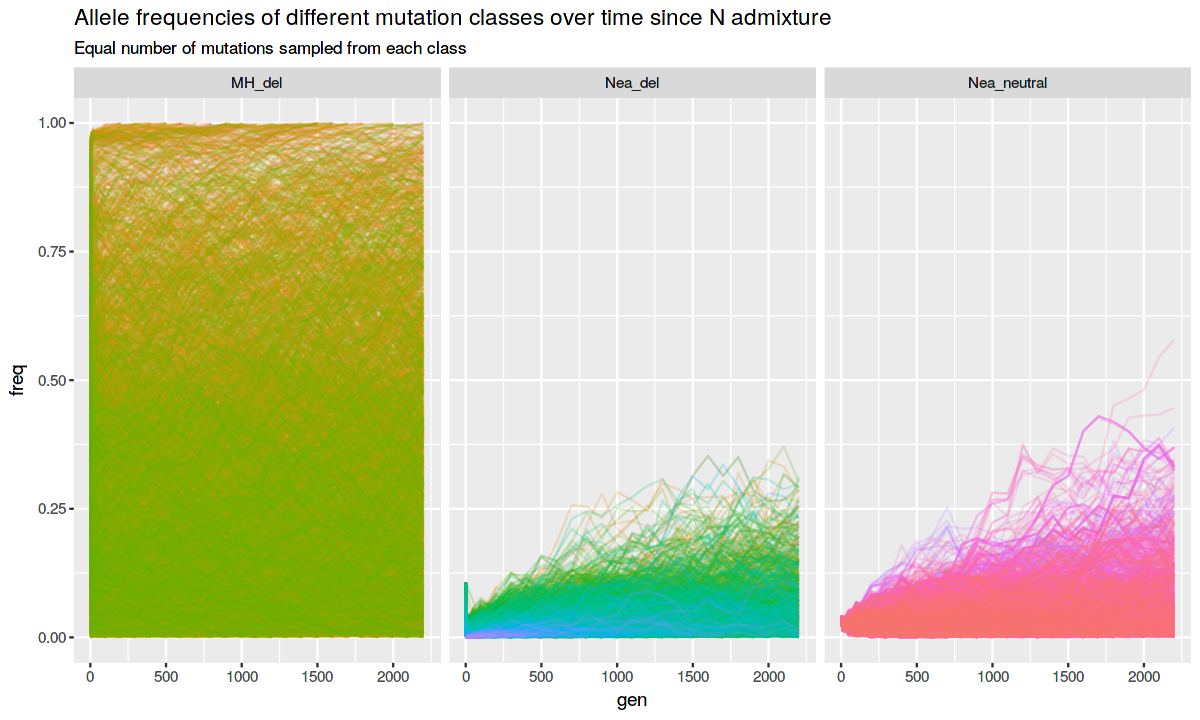

In [4]:
options(repr.plot.width=10, repr.plot.height=6)

bind_rows(nea_muts,
          arrange(mh_muts, MID)[1:nrow(nea_muts), ],
          arrange(markers, MID)[1:nrow(nea_muts), ]) %>%
ggplot(aes(gen, freq, color=factor(MID))) + geom_line(alpha=1/5) +
  facet_wrap(~ mutation) +
  theme(legend.position="none") +
  ggtitle("Allele frequencies of different mutation classes over time since N admixture",
          "Equal number of mutations sampled from each class")

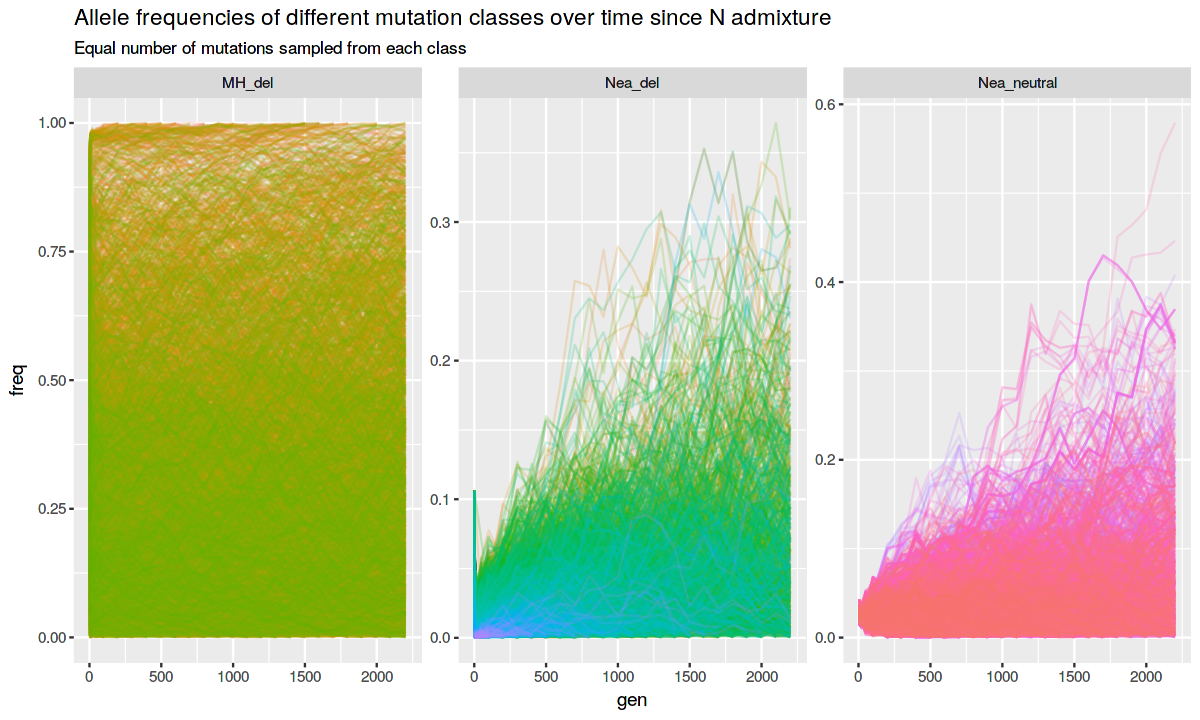

In [5]:
options(repr.plot.width=10, repr.plot.height=6)

bind_rows(nea_muts,
          arrange(mh_muts, MID)[1:nrow(nea_muts), ],
          arrange(markers, MID)[1:nrow(nea_muts), ]) %>%
  ggplot(aes(gen, freq, color=factor(MID))) + geom_line(alpha=1/5) +
  facet_wrap(~ mutation, scales="free") +
  theme(legend.position="none") +
  ggtitle("Allele frequencies of different mutation classes over time since N admixture",
          "Equal number of mutations sampled from each class")

In [6]:
# calculate changes in AF between simulation timepoints (use only those mutations with
# data in all generations)
calc_deltas <- function(mut_id, muts) {
  df <- muts[muts$MID == mut_id, ]
  if (nrow(df) < 2) return(NULL)
  tibble(g=df$gen[2:nrow(df)], t=diff(df$gen), delta_f=diff(df$freq) / t, MID=mut_id, logS=log10(-df$S[1]))
}

nea_deltas <- nea_muts %>% .[["MID"]] %>% unique %>% map_dfr(calc_deltas, nea_muts)
mh_deltas <- mh_muts %>% .[["MID"]] %>% unique %>% map_dfr(calc_deltas, mh_muts)
marker_deltas <- markers %>% .[["MID"]] %>% unique %>% map_dfr(calc_deltas, markers)

In [11]:
deltas <- bind_rows(
  mutate(nea_deltas, MID=as.character(MID), mutation="Nea deleterious"),
  mutate(mh_deltas[1:nrow(nea_deltas), ], MID=as.character(MID), mutation="MH deleterious"),
  mutate(marker_deltas[1:nrow(nea_deltas), ], MID=as.character(MID), mutation="Nea neutral markers")
) %>% select(-t)

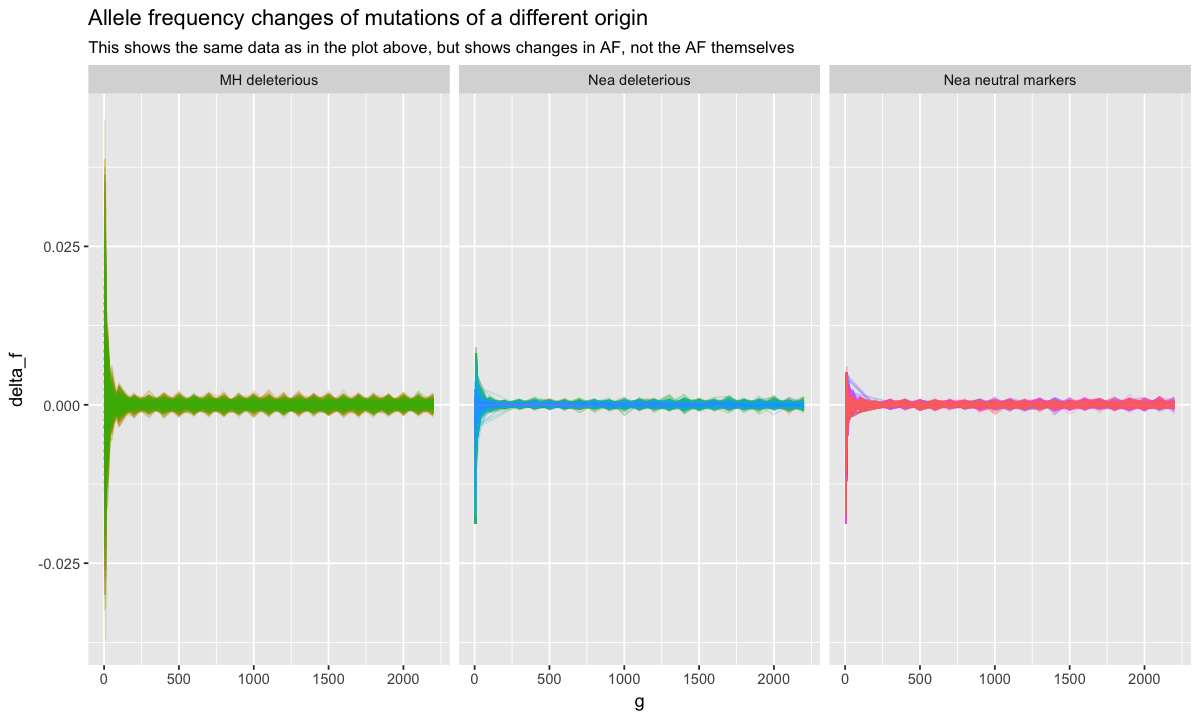

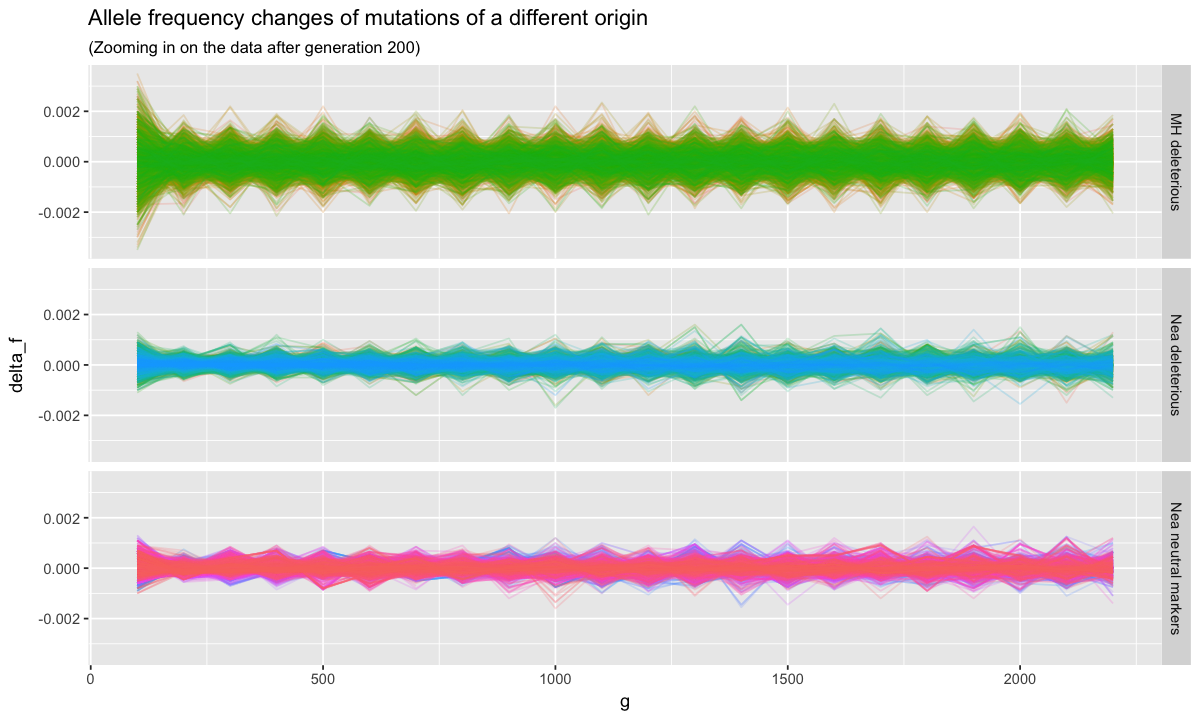

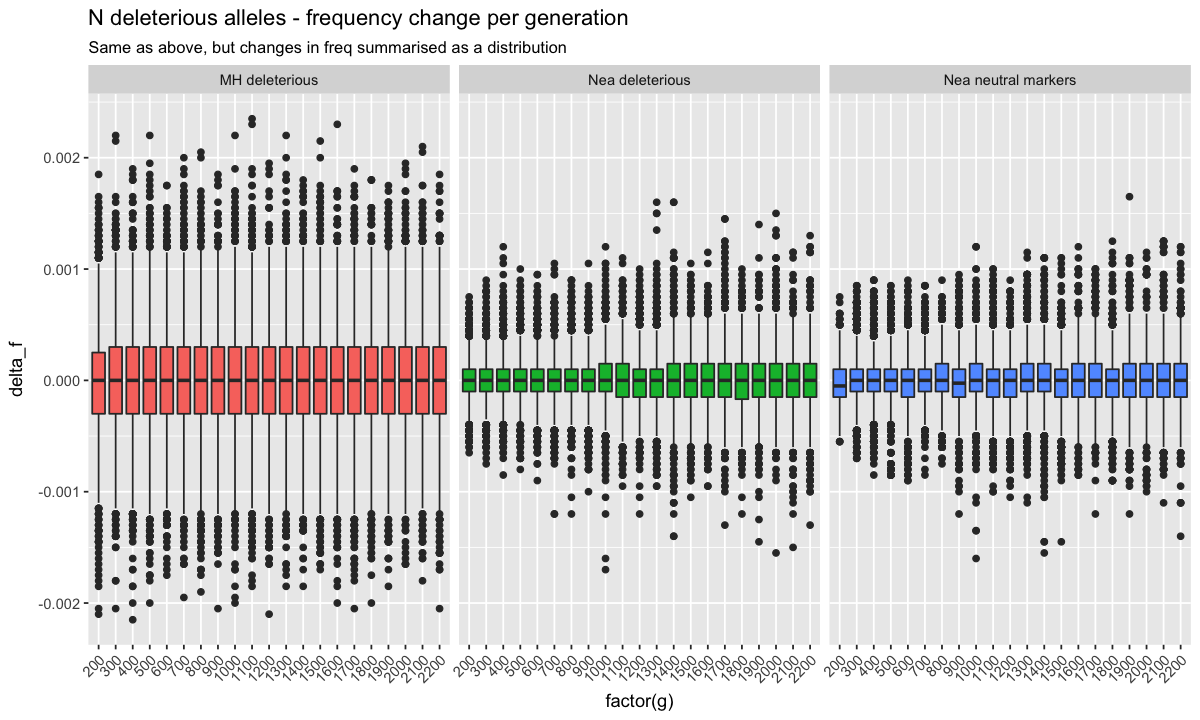

In [18]:
options(repr.plot.width=10, repr.plot.height=6)

deltas %>% ggplot(aes(g, delta_f, color=MID)) + geom_line(alpha=1/5) +
  facet_grid(. ~ mutation) + theme(legend.position="none") +
  ggtitle("Allele frequency changes of mutations of a different origin",
          "This shows the same data as in the plot above, but shows changes in AF, not the AF themselves")

filter(deltas, g >= 100) %>% ggplot(aes(g, delta_f, color=MID)) + geom_line(alpha=1/5) +
  facet_grid(mutation ~ .) + theme(legend.position="none") +
  ggtitle("Allele frequency changes of mutations of a different origin",
          "(Zooming in on the data after generation 200)")

filter(deltas, g >= 200) %>% ggplot(aes(factor(g), delta_f, fill=mutation)) + geom_boxplot() +
  facet_grid(. ~ mutation) + theme(legend.position="none", axis.text.x=element_text(hjust=1, angle=45)) +
  ggtitle("N deleterious alleles - frequency change per generation",
          "Same as above, but changes in freq summarised as a distribution")

In [13]:
# scaterplots of frequency deltas
deltas_wide <- bind_cols(
  rename(nea_deltas, delta_Nea=delta_f),
  rename(mh_deltas[1:nrow(nea_deltas), ], delta_MH=delta_f),
  rename(marker_deltas[1:nrow(nea_deltas), ], delta_marker=delta_f)
) %>% 
  select(-starts_with("MID"), -t, -g1, -t1, -g2, -t2)

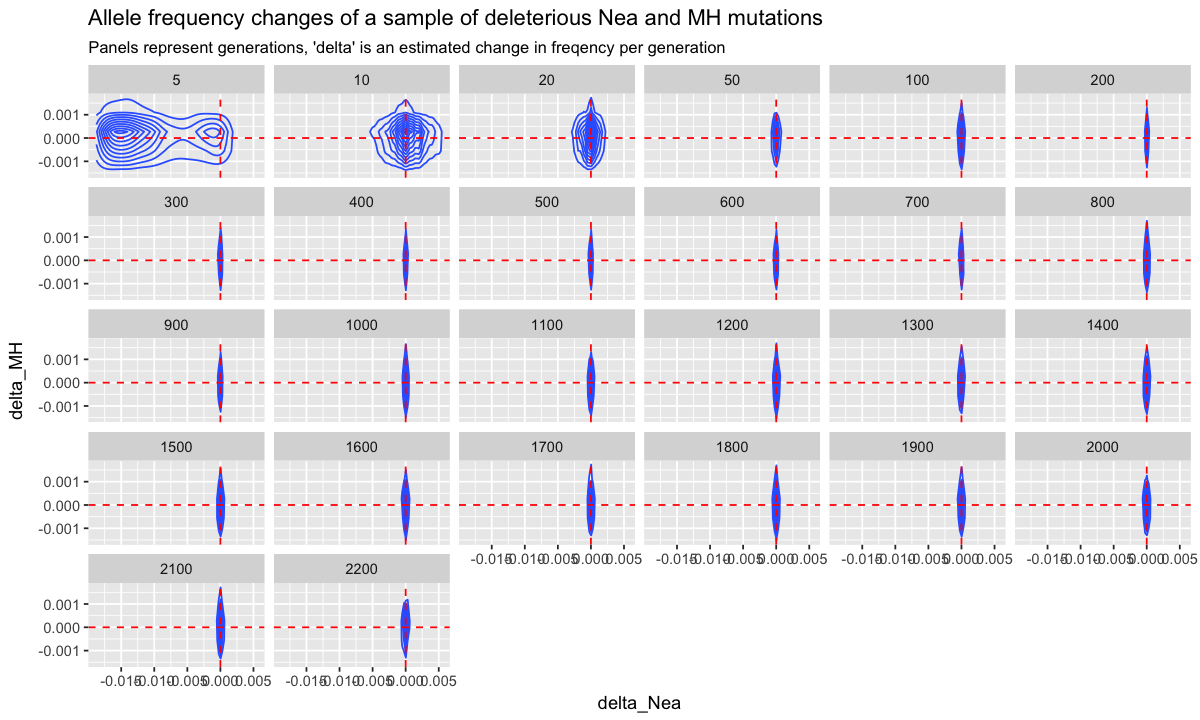

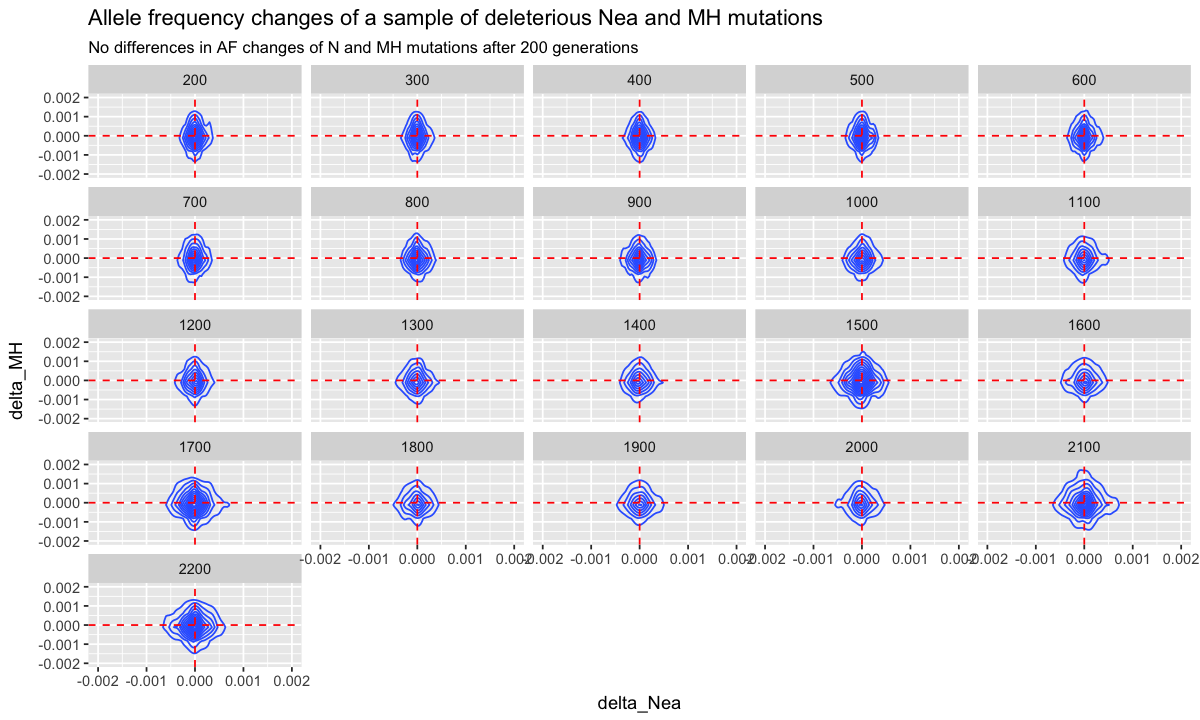

In [14]:
options(repr.plot.width=10, repr.plot.height=6)

# Nea vs MH delta
ggplot(deltas_wide, aes(delta_Nea, delta_MH)) + geom_density_2d() +
  geom_vline(xintercept=0, lty=2, color="red") +
  geom_hline(yintercept=0, lty=2, color="red") +
  facet_wrap(~ g) +
  ggtitle("Allele frequency changes of a sample of deleterious Nea and MH mutations",
          "Panels represent generations, 'delta' is an estimated change in freqency per generation")

ggplot(filter(deltas_wide, g >= 200), aes(delta_Nea, delta_MH)) + geom_density_2d() +
  geom_vline(xintercept=0, lty=2, color="red") +
  geom_hline(yintercept=0, lty=2, color="red") +
  facet_wrap(~ g) + coord_cartesian(y=c(-0.002, 0.002), x=c(-0.002, 0.002)) +
  ggtitle("Allele frequency changes of a sample of deleterious Nea and MH mutations",
          "No differences in AF changes of N and MH mutations after 200 generations")

In [14]:
bind_rows(nea_muts, mh_muts) %>% filter(gen == 1) %>% group_by(mutation) %>% mutate(logS=log10(-S)) %>%
filter(logS < log10(1/20000)) %>% tally()

mutation n    
1 MH_del   25041
2 Nea_del   3792

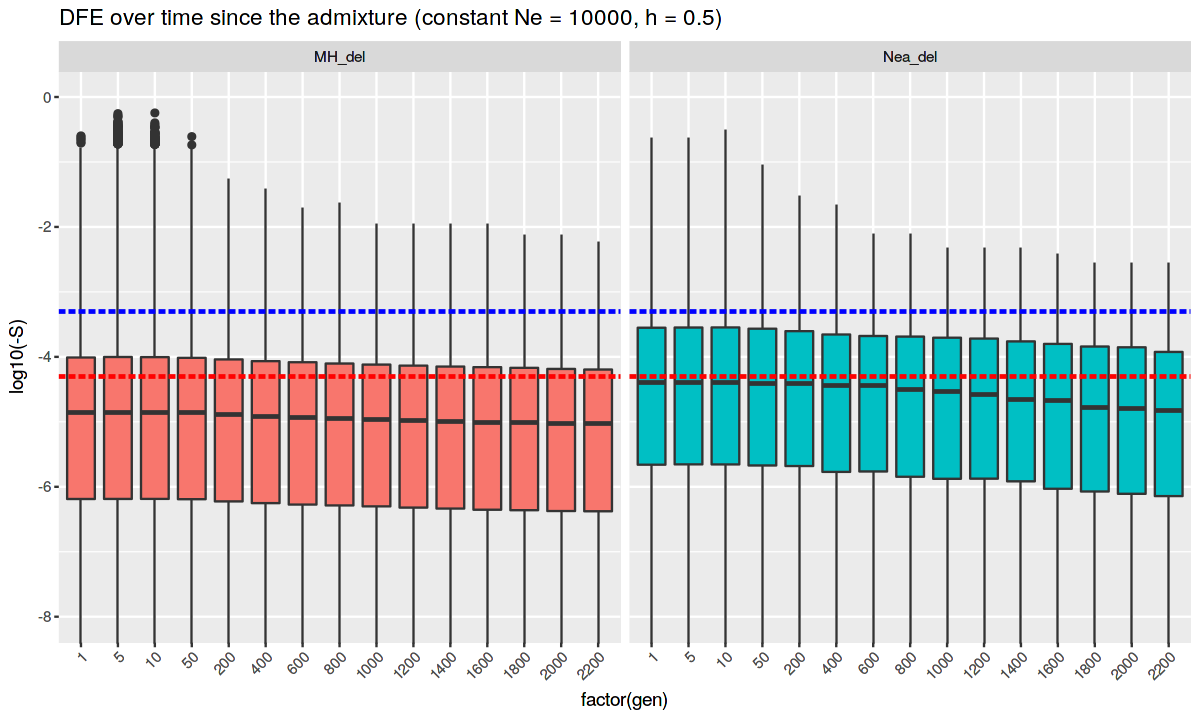

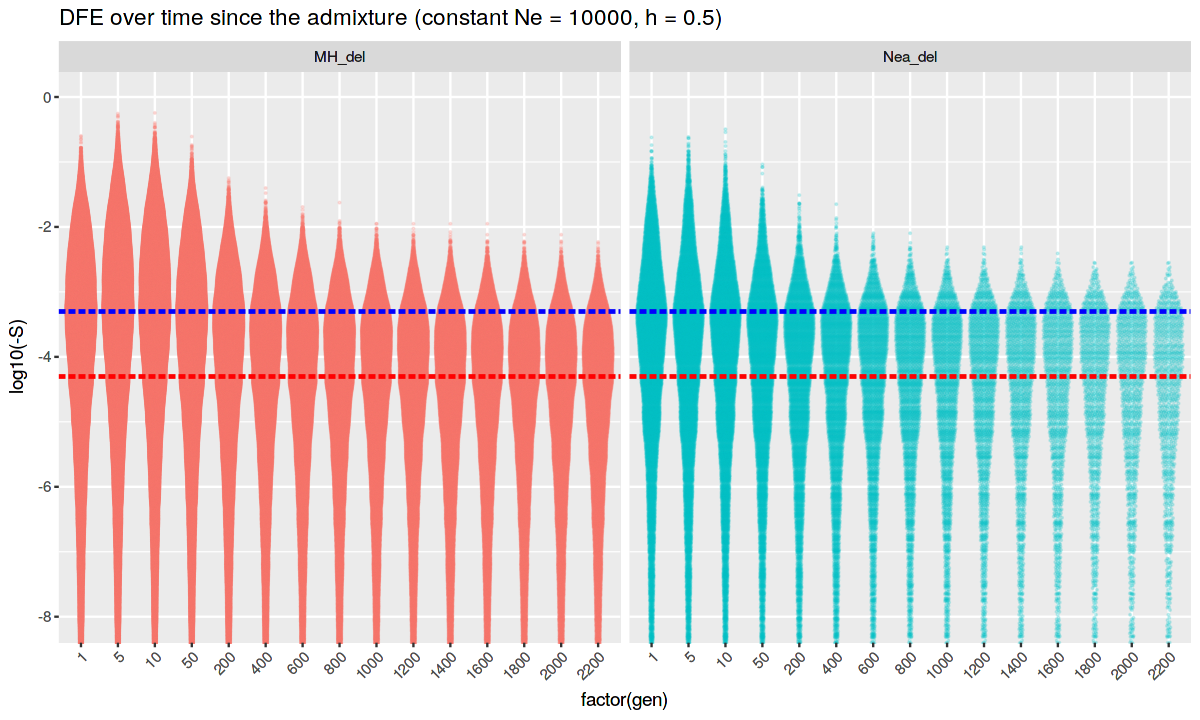

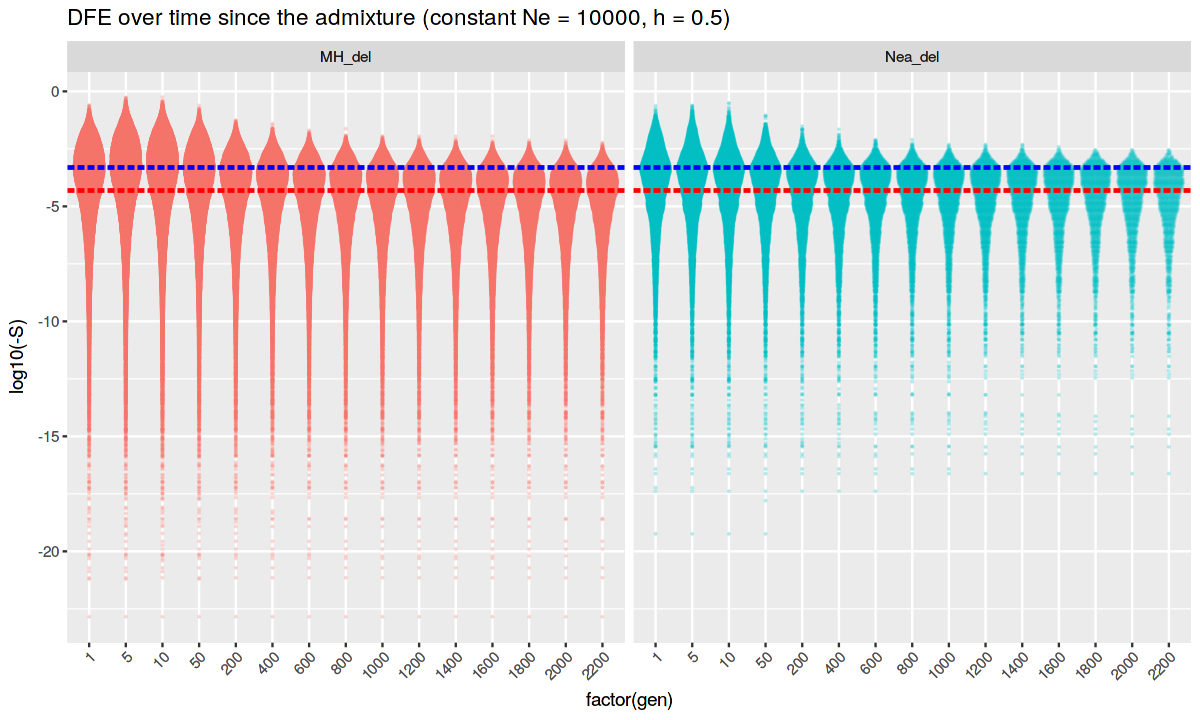

In [18]:
options(repr.plot.width=10, repr.plot.height=6)

# DFE plots
bind_rows(nea_muts, mh_muts) %>% filter(gen %in% c(1, 5, 10, 50, seq(200, 2200, 200))) %>% 
ggplot(aes(factor(gen), log10(-S), fill=mutation, weight=freq)) +
  geom_boxplot() +
  facet_wrap(~ mutation) +
  coord_cartesian(y=c(0, -8)) +
  theme(axis.text.x = element_text(angle=45, hjust=1), legend.position="none") +
  geom_hline(yintercept=log10(1/(2*10000)), linetype=5, size=1, color="red") +
  geom_hline(yintercept=log10(1/(2*1000)), linetype=5, size=1, color="blue") +
  labs(title="DFE over time since the admixture (constant Ne = 10000, h = 0.5)")

bind_rows(nea_muts, mh_muts) %>% filter(gen %in% c(1, 5, 10, 50, seq(200, 2200, 200))) %>% 
ggplot(aes(factor(gen), log10(-S), color=mutation, weight=freq)) +
  geom_quasirandom(alpha=1/5, size=0.1) +
  facet_wrap(~ mutation) +
  coord_cartesian(y=c(0, -8)) +
  theme(axis.text.x = element_text(angle=45, hjust=1), legend.position="none") +
  geom_hline(yintercept=log10(1/(2*10000)), linetype=5, size=1, color="red") +
  geom_hline(yintercept=log10(1/(2*1000)), linetype=5, size=1, color="blue") +
  labs(title="DFE over time since the admixture (constant Ne = 10000, h = 0.5)")

bind_rows(nea_muts, mh_muts) %>% filter(gen %in% c(1, 5, 10, 50, seq(200, 2200, 200))) %>% 
ggplot(aes(factor(gen), log10(-S), color=mutation, weight=freq)) +
  geom_quasirandom(alpha=1/5, size=0.1) +
  facet_wrap(~ mutation) +
  theme(axis.text.x = element_text(angle=45, hjust=1), legend.position="none") +
  geom_hline(yintercept=log10(1/(2*10000)), linetype=5, size=1, color="red") +
  geom_hline(yintercept=log10(1/(2*1000)), linetype=5, size=1, color="blue") +
  labs(title="DFE over time since the admixture (constant Ne = 10000, h = 0.5)")

In [16]:
mut_counts <- map_dfr(gens, function(g) {
  vcf <- readVcf(paste0("../data/simulations/af_changes_exon_h_0.5_rep_1_gen_", g, ".vcf.gz"))
  
  n_muts <- mut_info(vcf, mut_type=0, pop_origin=2, t_min=70000) %>% sort
  h_muts <- mut_info(vcf, mut_type=0, pop_origin=1, t_min=70000) %>% sort
  
  windows <- flank(n_muts, 25000, both=TRUE) %>% granges
  
  n_hits <- findOverlaps(windows, n_muts)
  n_rle <- rle(queryHits(n_hits))
  windows$nea <- 0
  windows$nea[n_rle$values] <- n_rle$lengths
  
  h_hits <- findOverlaps(windows, h_muts)
  h_rle <- rle(queryHits(h_hits))
  windows$mh <- 0
  windows$mh[h_rle$values] <- h_rle$lengths
  
  as.data.frame(windows) %>% select(nea, mh) %>% mutate(gen=g)
})

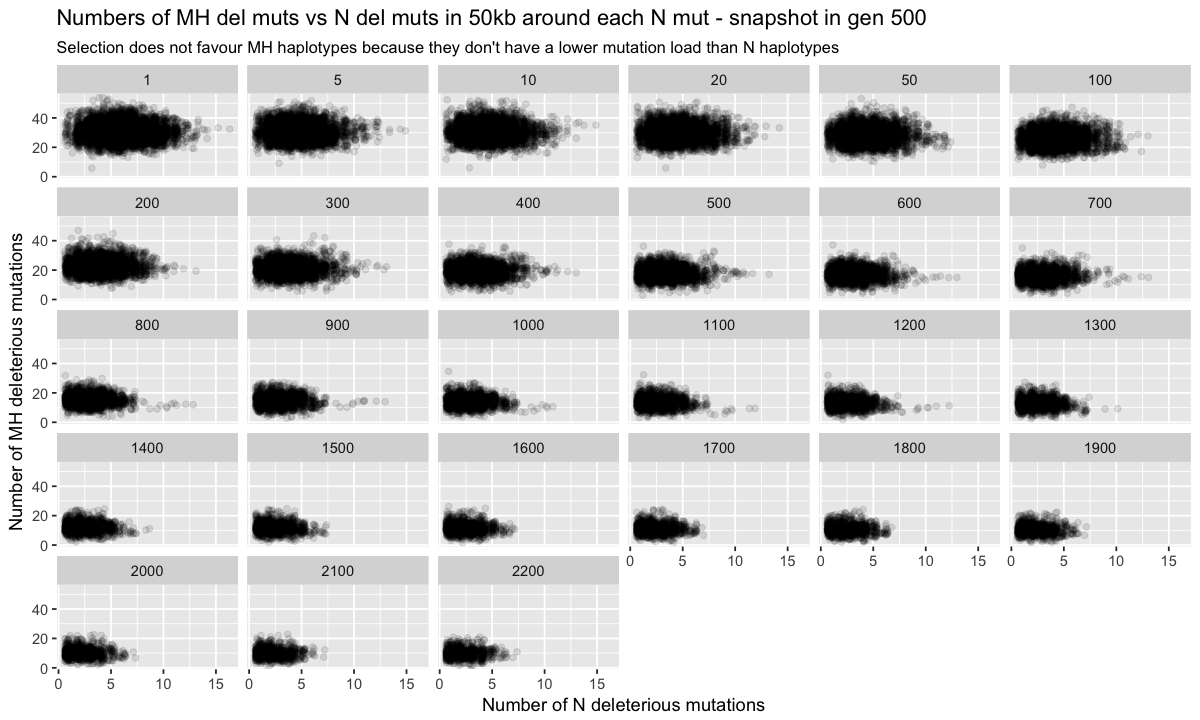

In [17]:
mut_counts %>% ggplot(aes(nea, mh)) + geom_jitter(alpha=1/10) + facet_wrap(~ gen) +
  labs(y="Number of MH deleterious mutations", x="Number of N deleterious mutations") +
  ggtitle("Numbers of MH del muts vs N del muts in 50kb around each N mut - snapshot in gen 500",
          "Selection does not favour MH haplotypes because they don't have a lower mutation load than N haplotypes")

In [21]:
save.image("~/projects/nea-over-time/data/RData/selection_efficacy.rds")